In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import time
from sklearn import *
import re
from tqdm import*
import warnings
import catboost as ctb
import lightgbm as lgbm
warnings.filterwarnings('ignore')
tqdm.pandas()
from collections import*
import umap
plt.style.use('ggplot')

In [2]:

df = pd.read_csv('data/avito_data_clean.csv',
                 parse_dates=[4]
                )

Optimize data

In [3]:
df.loc[:,df.select_dtypes(include=['int','float']).columns] = df.select_dtypes(include=['int','float']).apply(pd.to_numeric,downcast='unsigned')

EDA : Простое EDA для поиска очевидный выбросов

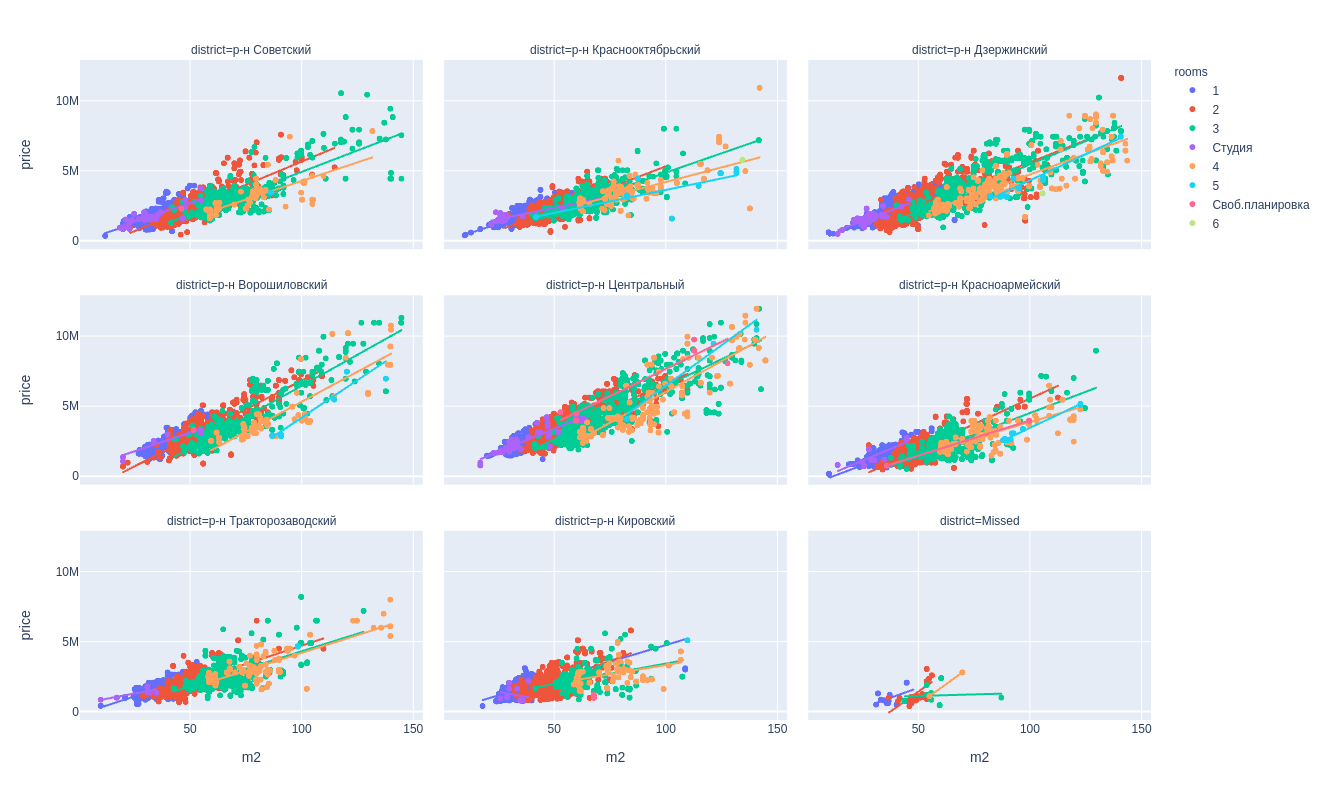

In [4]:
pre_fix_scatter=px.scatter(df,x='m2',y='price',color='rooms',facet_col='district',facet_col_wrap=3,height=800,trendline='ols',)
pre_fix_scatter

В сете присутствуют аномольно большие квартиры, которые могут являться неправильно размещенными\описанными нежилыми помещениями\рекламой\опечатками  
Так же для удаления ошибок завышенной стоимости , используется комбинированый показатель ,   
позволяющий одновременно убрать ошибки при выставлении на продажу объекта ( лишний нули например), так и сильно завышенных цен, что будет мешать нашей модели   
Для составления модели, хватит 3 сигма разброса данных параметров

In [5]:
df=df[df['m2']<np.percentile(df.m2,99.5)]
df=df[df['rubm2']<np.percentile(df['rubm2'],99.5)]

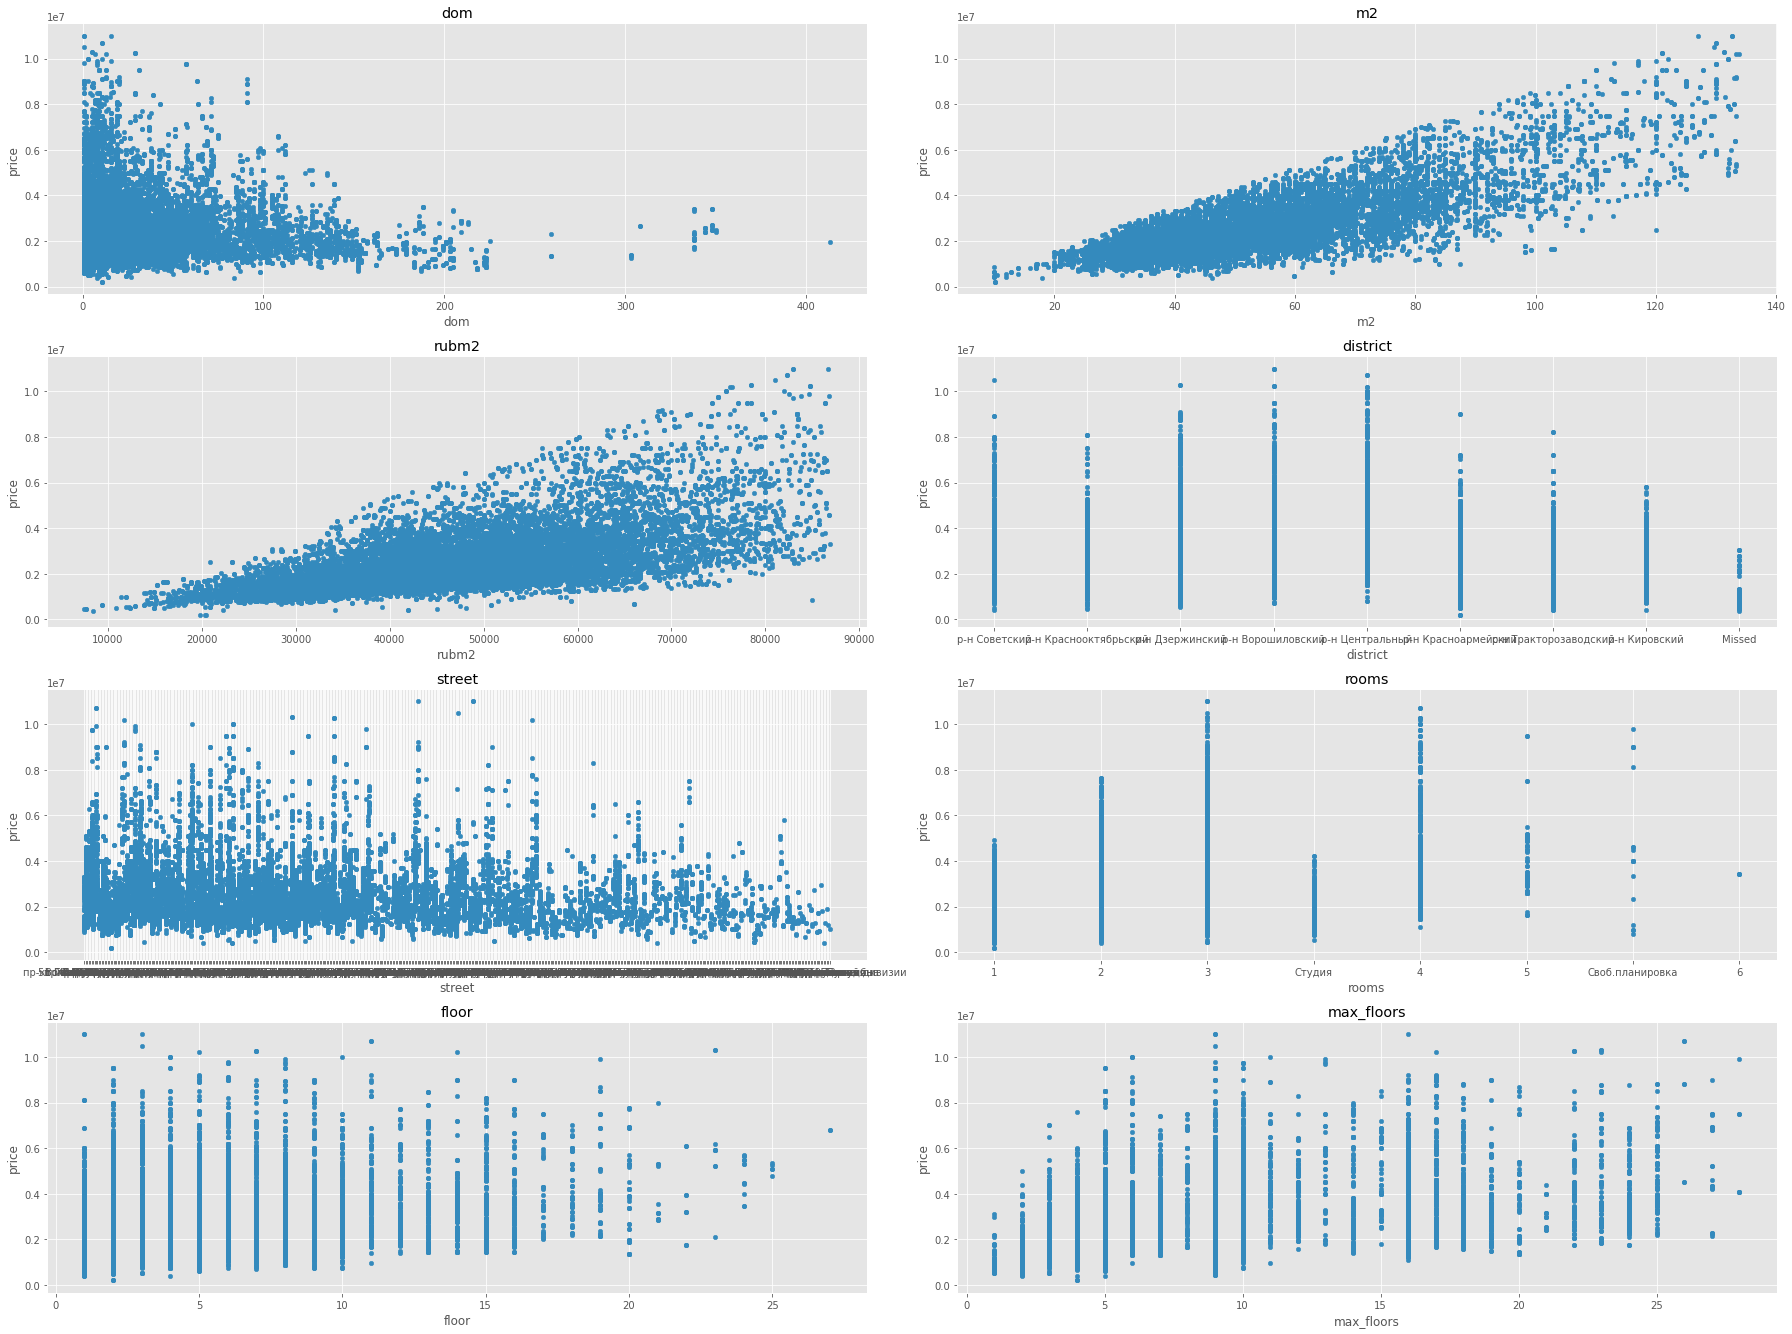

In [6]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['dom','m2','rubm2','district','street','rooms','floor','max_floors']])):
    ax=fig.add_subplot(19,2,j+1)
    ax.set_title(column)
    df.plot.scatter(x=column,y='price',ax=ax)
    plt.tight_layout()

Скаттер вполне наглядно показывает что наши данные не сильно единообразны в своих распределениях, но в целом подходят для работы    
Можно стразу выделить очевидный паттерны в виде увеличения стоимости в зависимости от райна и размера квартиры  
Интересно, что при этом паттерн не сохраняется в фиче количества комнат

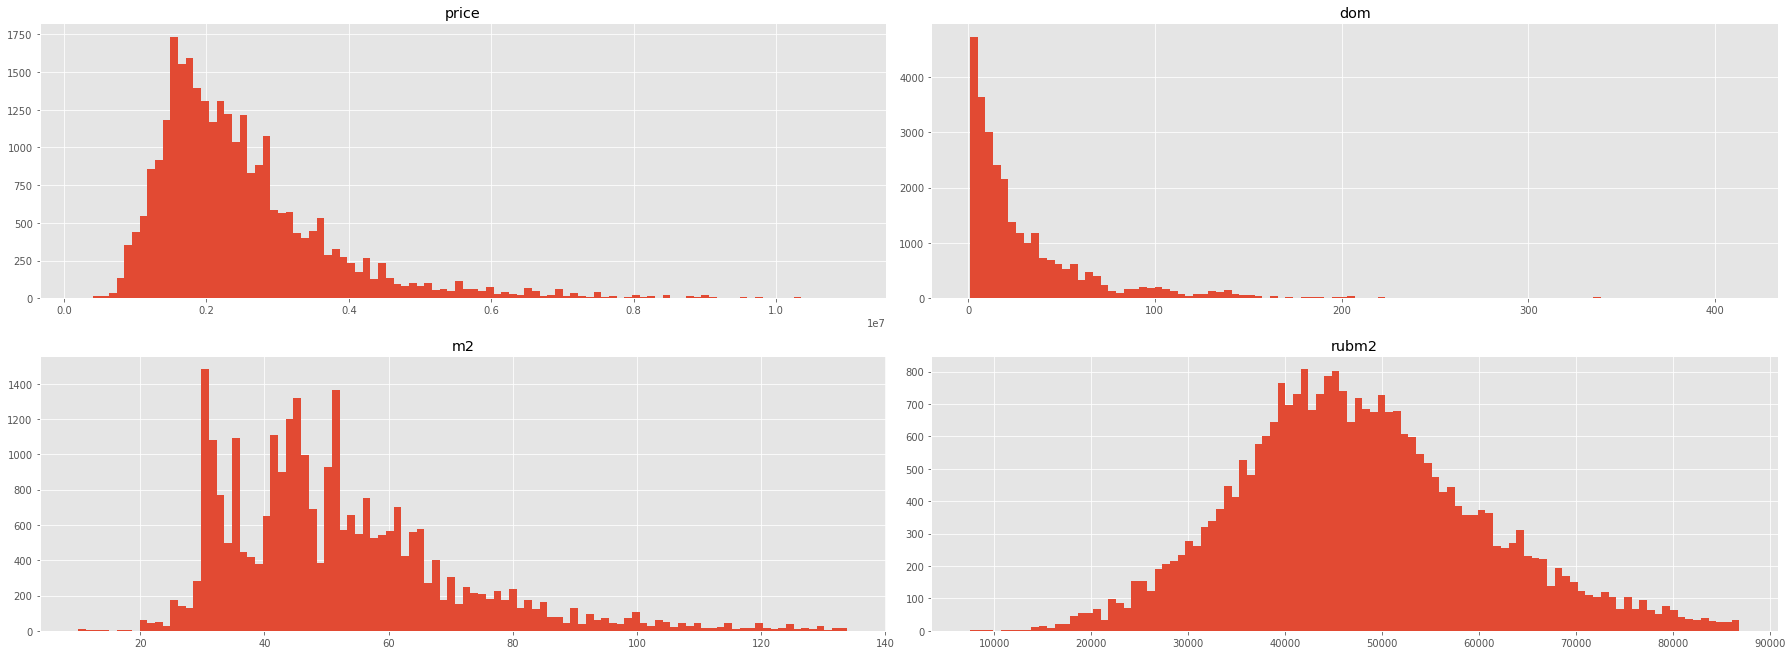

In [7]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['price', 'dom', 'm2', 'rubm2']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].hist(bins=100,ax=ax)
  plt.tight_layout()

По графикам видно распределение числовых показателей, которые в принципе ,      
 хоть и скошены, но либо приводимы к нормальному, либо почти таковыми и являются, как цена за м2 площади

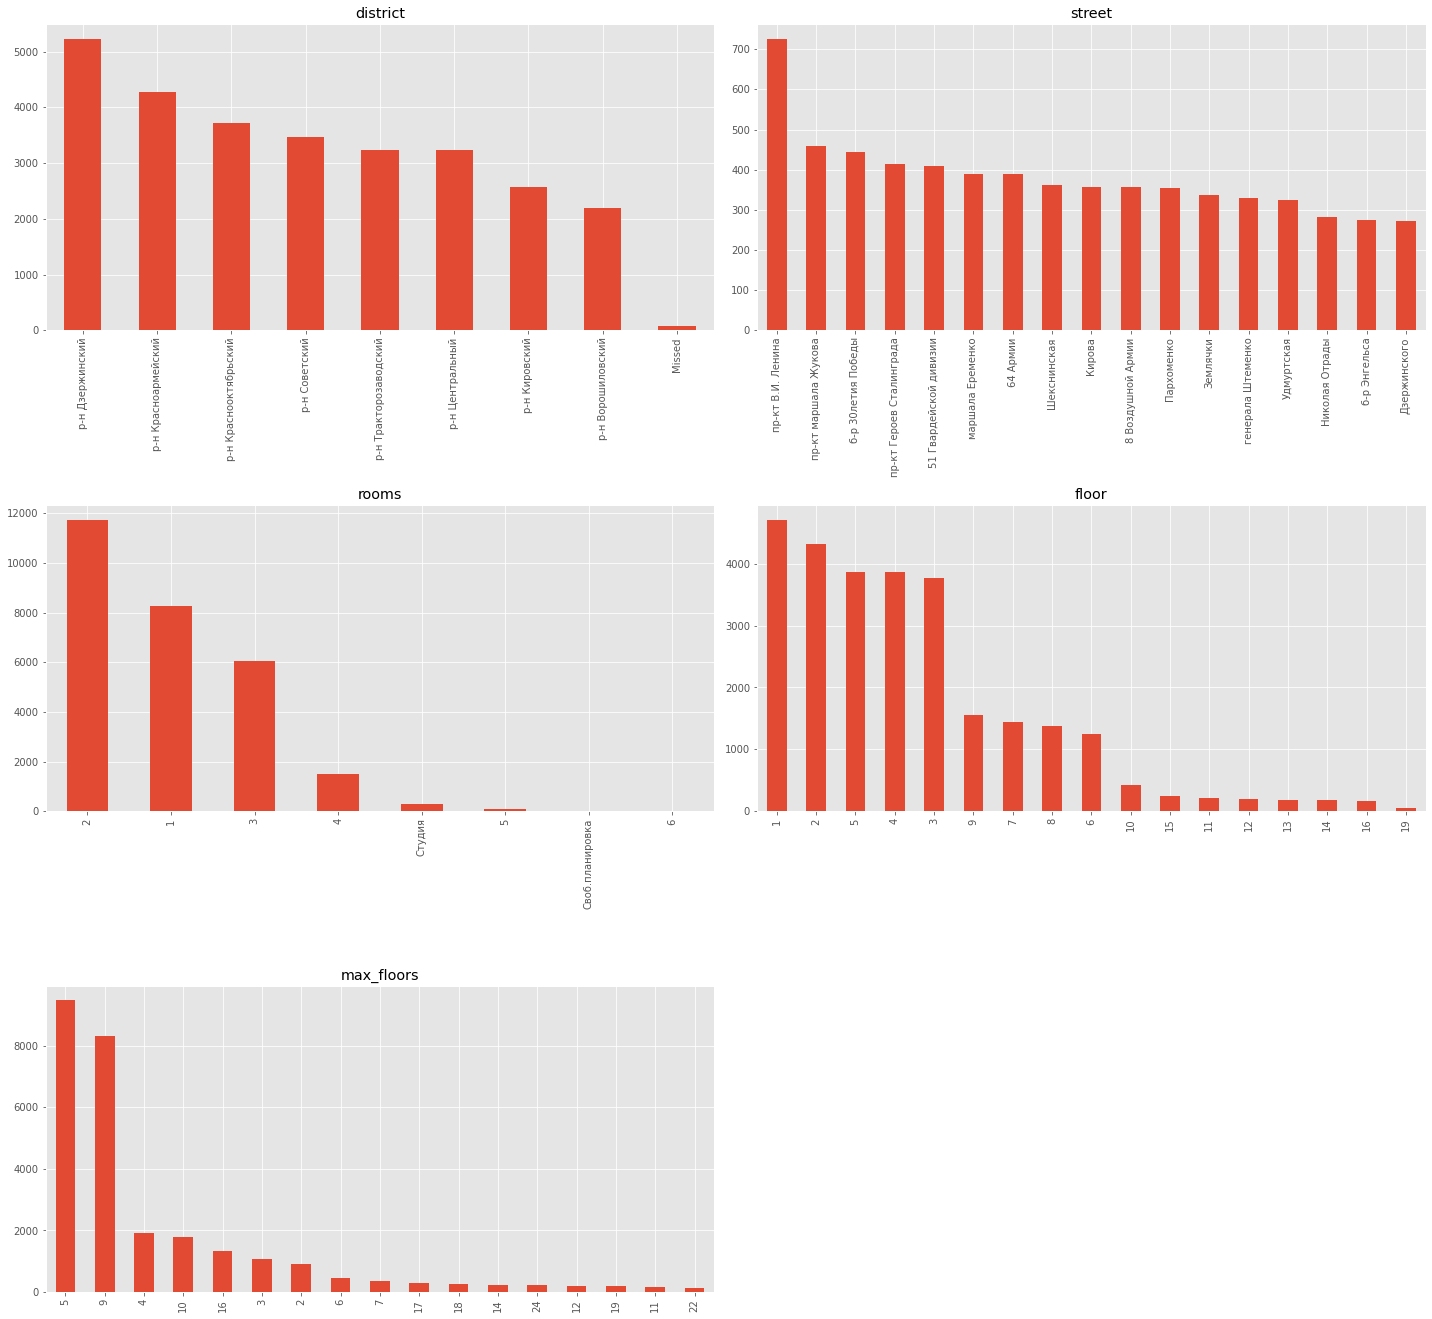

In [8]:
fig = plt.figure(figsize=(20,50*2.5))
for j,column in tqdm_notebook(enumerate(df[['district','street',
       'rooms', 'floor','max_floors']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].value_counts()[:17].plot.bar(ax=ax)
  plt.tight_layout()

И снова небольшая репрезентация наших данных, из которых мы сможем сделать некие наивные предположения об паттернах которые модели будут полезны    
В целом что позволит построить эффективные фичи в будущем

array([<AxesSubplot:title={'center':'m2'}, xlabel='district'>,
       <AxesSubplot:title={'center':'rubm2'}, xlabel='district'>,
       <AxesSubplot:title={'center':'max_floors'}, xlabel='district'>],
      dtype=object)

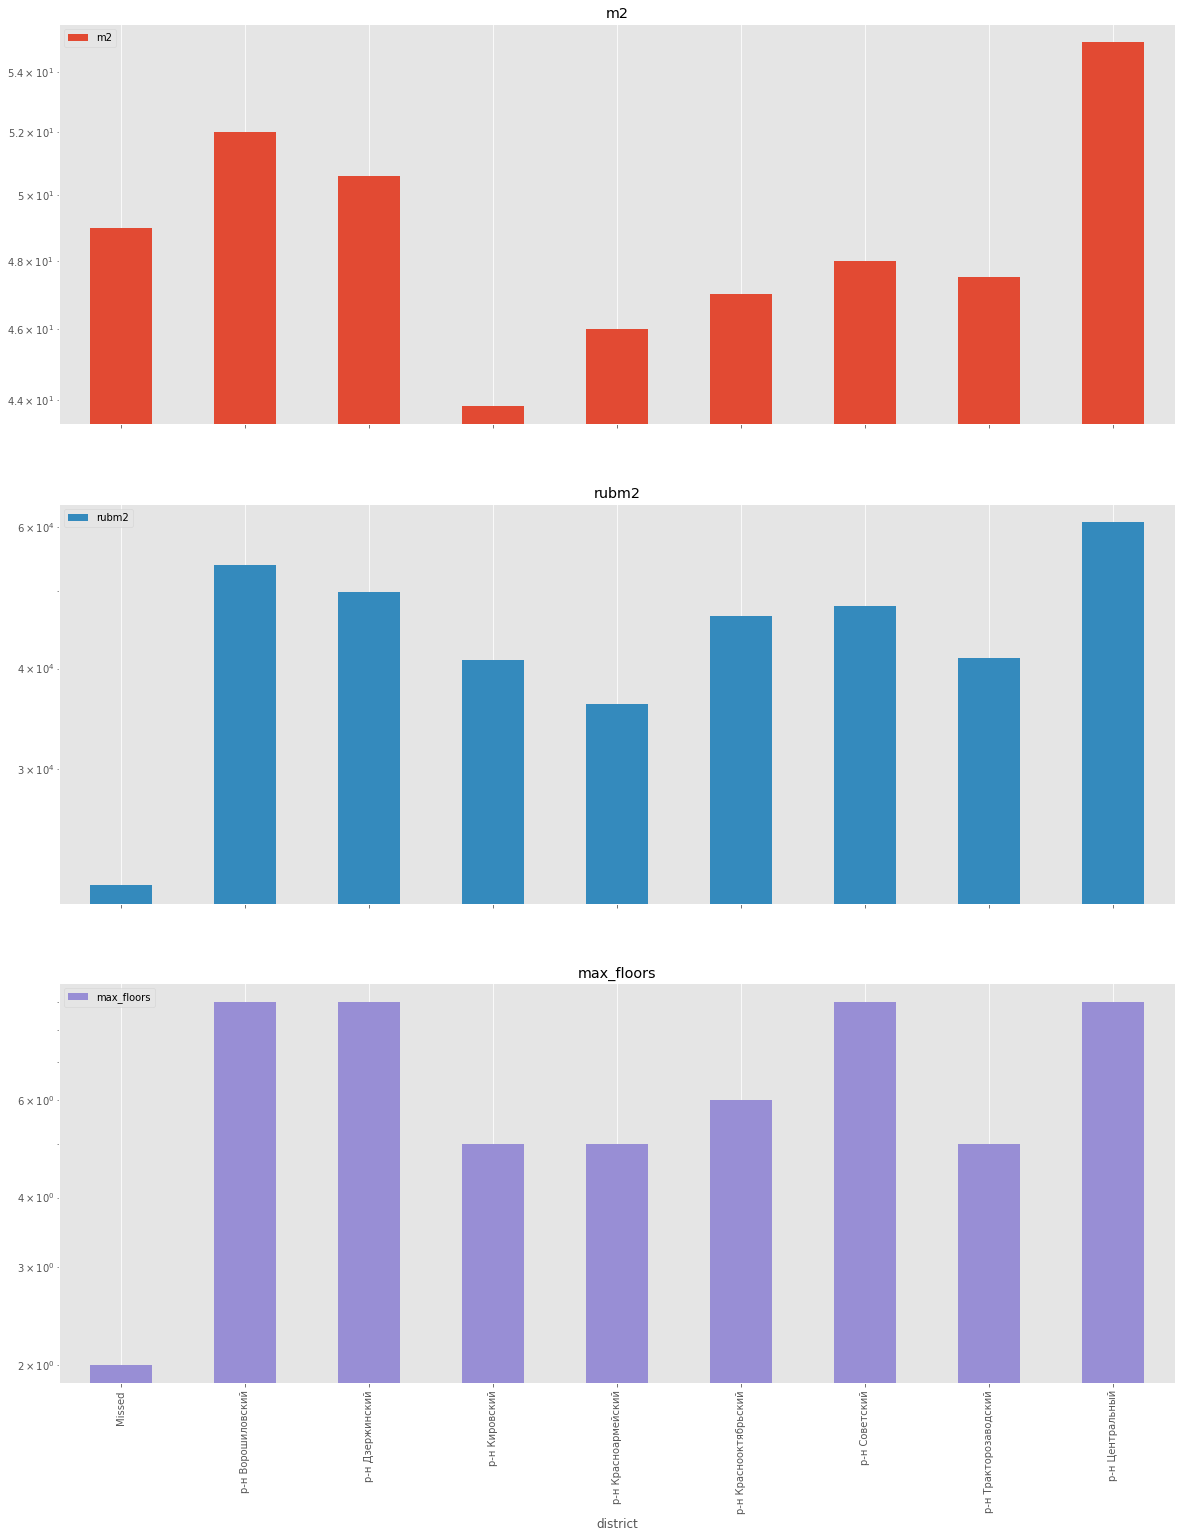

In [9]:
df.groupby(['district'])[['m2','rubm2','max_floors']].median().plot.bar(subplots=True,logy=True,figsize=(20,25))

array([<AxesSubplot:title={'center':'rubm2'}, xlabel='street'>,
       <AxesSubplot:title={'center':'m2'}, xlabel='street'>], dtype=object)

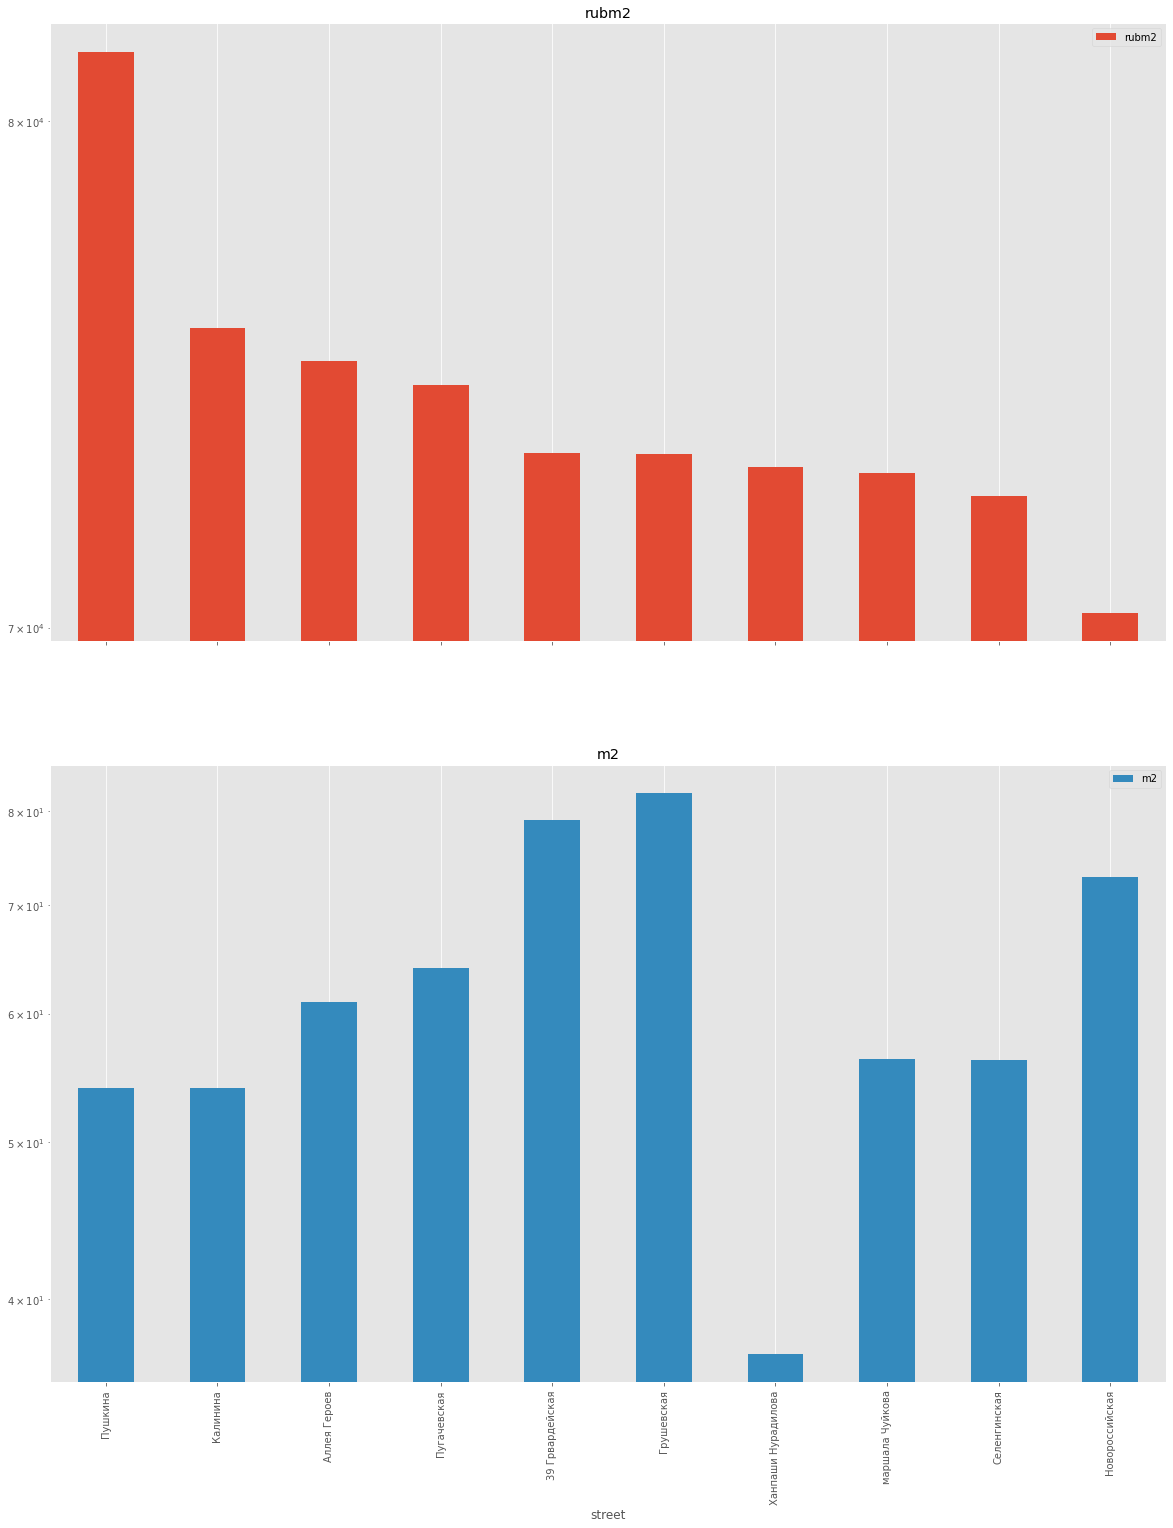

In [10]:
df.groupby('street')['rubm2','m2'].median().sort_values(by='rubm2',ascending=False)[:10].plot.bar(subplots=True,logy=True,figsize=(20,25))

Feature Engineering

In [11]:
d_r_m_f_s = ['district','rooms','max_floors','floor','street']


In [12]:
def gb_fe(df,cols,targ,typ='mean'):
    for col in range(len(cols)):
        df['_'.join(cols[col:])+'_'+typ] = df.groupby(cols[col:])[targ].transform(typ).fillna(0)
    return df.shape

In [13]:
for i in ['mean','std','min','max']:
    gb_fe(df,d_r_m_f_s,'rubm2',i)

df['count_by_dist'] = df.groupby(['district']).clean.transform('count')
df['count_by_str'] = df.groupby(['street']).dom.transform('count')

In [14]:
data = df.drop(['price','rubm2','clean','date','info','adress'],axis=1)
targ = df['price']
data_m = df.drop(['price','clean','date','info','adress'],axis=1)

Для упрощения препроцессинга я использовал словарь (точнее модуль из collections),  
 что бы хранить Энкодер для кажой колонки и упрощения кода использовал метод apply

In [15]:
d_=defaultdict(preprocessing.LabelEncoder)

In [16]:
data.loc[:,data.select_dtypes(include=['category','O']).columns] = data.progress_apply\
(lambda x: d_[x.name].fit_transform(x) if x.dtype not in [float,int] else x)

100%|██████████| 29/29 [00:00<00:00, 1862.91it/s]


Choosing and Train models

In [17]:
x,xv,y,yv = model_selection.train_test_split(data,targ,test_size= 0.2)

In [18]:
cat_feats=['district','street','rooms','max_floors']

In [19]:
lgb_set = lgbm.Dataset(data,targ,categorical_feature=cat_feats)

Обычно значительную часть успеха модели составляет правильно подобранная и хорошо обработанная выборка.     
Для этого по полному сету прогоняется простая cv для оценки в целом сета

In [20]:
params ={'n_estimators':5000,
     "objective" : "regression",
        "metric" : "rmse"}

In [21]:
lgb_cv = lgbm.cv(params=params,train_set=lgb_set,nfold=3,stratified=False,verbose_eval=1000)

[1000]	cv_agg's rmse: 165487 + 3336.2
[2000]	cv_agg's rmse: 162014 + 3443.17
[3000]	cv_agg's rmse: 160917 + 3377.73
[4000]	cv_agg's rmse: 160626 + 3316.62
[5000]	cv_agg's rmse: 160489 + 3251.67


Простое упрощение валидации и сбора информации по работе,   
 на вход принимает бустер и словарь и на основе его формирует результаты и сохраняет в соловарь

In [22]:
def score_comp(booster,dic,values=None,predict=True):
    for i in [metrics.r2_score,metrics.mean_absolute_error,metrics.mean_squared_error]:
        if predict==True:
            dic[booster.__class__.__name__].append(np.sqrt(i(yv,booster.predict(xv))))
        else:
            dic[booster].append(i(yv,values))

score = defaultdict(list)

In [23]:
cat = ctb.CatBoostRegressor(iterations = 5000, verbose=200,
                                early_stopping_rounds=500,
                               cat_features=[0,1,2,3]
                           )

cat.fit(x,y,eval_set=(xv,yv))

score_comp(cat,score)

Learning rate set to 0.030425
0:	learn: 1208501.3139210	test: 1186945.7152772	best: 1186945.7152772 (0)	total: 82.1ms	remaining: 6m 50s
200:	learn: 194312.3939924	test: 198305.1701536	best: 198305.1701536 (200)	total: 2.12s	remaining: 50.7s
400:	learn: 181295.6131300	test: 187070.3731194	best: 187070.3731194 (400)	total: 3.76s	remaining: 43.2s
600:	learn: 172503.3305700	test: 181641.9029004	best: 181629.6656558 (599)	total: 5.46s	remaining: 40s
800:	learn: 164906.0136122	test: 177556.1779485	best: 177556.1779485 (800)	total: 7.08s	remaining: 37.1s
1000:	learn: 159436.1963515	test: 175005.8049965	best: 175005.8049965 (1000)	total: 8.7s	remaining: 34.7s
1200:	learn: 154982.0197471	test: 173458.1430273	best: 173458.1430273 (1200)	total: 10.3s	remaining: 32.7s
1400:	learn: 150703.0127102	test: 172108.1809949	best: 172103.0088346 (1399)	total: 12s	remaining: 30.8s
1600:	learn: 147474.0705407	test: 170860.8268188	best: 170856.6579647 (1599)	total: 13.6s	remaining: 28.9s
1800:	learn: 144557.7

In [24]:
from bayes_opt import BayesianOptimization

In [25]:
X_train=data # analysing data
y_train=targ #analysing target
categorical_features=cat_feats #categorical features in set
#num of parametrs must match in lgb_eval & optimisition
def lgb_eval(num_leaves,lambda_l2,lambda_l1,
             mcw,
             lr):
    #parametrs for tuning
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        'min_child_weight':mcw,
        'is_unbalance': False,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "learning_rate" : lr,
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    
    cv_result = lgbm.cv(params,
                       lgtrain,
                       5000,
                       early_stopping_rounds=500,
                       stratified=False,
                       nfold=3)
    return -cv_result['rmse-mean'][-1]

In [26]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 50),
                                                'lambda_l2': (0.0, 8),
                                                'lambda_l1': (0.0, 8),
                                                'mcw':(0.0001,0.1),
                                                'lr':(0.001,0.1)
                                                })

lgbBO.maximize(n_iter=10, init_points=10)

|   iter    |  target   | lambda_l1 | lambda_l2 |    lr     |    mcw    | num_le... |
-------------------------------------------------------------------------------------
|  1        | -1.611e+0 |  6.576    |  6.536    |  0.08727  |  0.0718   |  20.89    |
|  2        | -1.609e+0 |  7.328    |  2.931    |  0.05065  |  0.06098  |  28.19    |
|  3        | -1.612e+0 |  7.128    |  5.239    |  0.0746   |  0.002041 |  20.95    |
|  4        | -1.644e+0 |  4.041    |  6.442    |  0.02624  |  0.04753  |  25.83    |
|  5        | -1.595e+0 |  3.812    |  0.2989   |  0.0958   |  0.02751  |  38.24    |
|  6        | -1.594e+0 |  3.413    |  1.89     |  0.09341  |  0.09142  |  36.62    |
|  7        | -1.694e+0 |  3.571    |  2.867    |  0.0316   |  0.09407  |  14.03    |
|  8        | -1.591e+0 |  0.9403   |  0.9314   |  0.04998  |  0.07634  |  39.35    |
|  9        | -1.682e+0 |  6.71     |  5.885    |  0.02264  |  0.09926  |  20.29    |
|  10       | -1.858e+0 |  4.099    |  1.911    |  0.0

In [27]:
prms=lgbBO.max['params']
prms['num_leaves'] = int(prms['num_leaves'])

In [28]:
lgb=lgbm.LGBMRegressor(**prms,n_estimators=5000,
categorical_features=cat_feats,random_state=1)
lgb.fit(data,targ)
score_comp(lgb,score)

Попытка смешать результаты моделей с разным подходом для получение более взвешенной оценки

In [29]:
blend_boosters = cat.predict(xv)*.5+lgb.predict(xv)*.5

score_comp('blend_boosters',score,values=blend_boosters,predict=False)

#blend = cat.predict(xv)*.35+lgb.predict(xv)*.35 + knn.predict(xv)*.3

#score_comp('blend',score,values=blend,predict=False)


In [30]:
pd.DataFrame(score,index=['R2','MAE','RMSE']).T.style

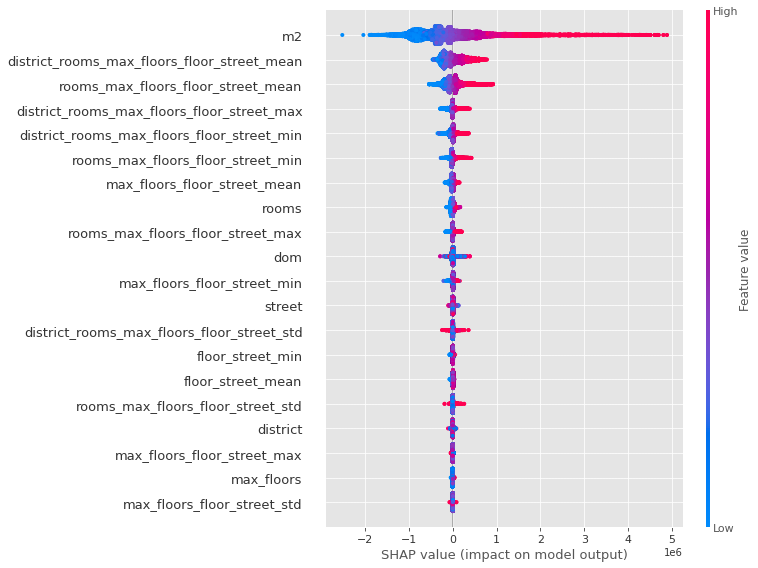

In [31]:
import shap

expl_c=shap.TreeExplainer(cat)

shap_val_c=expl_c.shap_values(data,targ)

shap.summary_plot(shap_val_c,data)

In [32]:
import joblib

In [33]:
joblib.dump(lgb,f'models/LGB_apart_{df.shape[0]}.pkl')
joblib.dump(cat,f'models/Catboost_apart_{df.shape[0]}.pkl')
joblib.dump(d_,f'models/def_dict_{df.shape[0]}.pkl')

['models/def_dict_28002.pkl']

In [34]:
data_m.to_pickle(f'data/merge_data_{df.shape[0]}.pkl')